In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
NL_t = 0.4
emitGeomRMS = 3.3e-6
npt = 40000
print('npt=',npt)
nturn = 2000

npt= 40000


In [3]:
NL_L = 1.8
NL_c = 0.01
NL_nu = 0.3

# read Aperture

In [4]:
aperture = np.loadtxt('pipeinfo.in')

In [5]:
aperture[-1,0]

39.968229720000004

# read impact lattice

In [6]:
beam,lattice = impact.readInputFile('test.Chad.in')
beam.nCore_y=4
beam.nCore_z=2
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg
print('\n\n emitN =',emitN)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


 emitN = 2.4105916749973357e-07


In [7]:
cleanLat = impact.clearLattice(lattice)
L = 0 
for item in cleanLat:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        NLfoward = item
        print('NL:',L,L+item.length)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NLfoward.n_sckick = 2
NLfoward.n_map = 45

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [8]:
NLfoward


             length: 1.8 [m]
           n_sckick: 2 [1]
              n_map: 45 [1]
         strength_t: 0.4
 transverse_scale_c: 0.01
        pipe_radius: 10.0 [m]
       tune_advance: 0.3
               type: 'nonlinear_insert'

In [9]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

add quadrupole fringe hard-edge model

In [10]:
quadIndex = []
quadStr = []
for i,item in enumerate(cleanLat):
    if item.type=='quad':
        quadIndex.append(i)
        quadStr.append(item.Kx)
        
for i,j in enumerate(quadIndex):
    heqf1 = impact.getElem('quad_hardedge')
    heqf1.n_sckick = 100
    heqf1.flagEntrance=True
    heqf1.Kx = quadStr[i]
    cleanLat.insert(j+2*i,heqf1)
    heqf2 = copy(heqf1)
    heqf2.flagEntrance=False
    cleanLat.insert(j+2*i+2,heqf2)

# Back tracking for IOTA matched beam at injection location

In [11]:
for i in range(len(cleanLat)):
    if cleanLat[i].type == 'nonlinear_insert':
        break

latticeB = impact.getInverseLattice(cleanLat[:i])

write0 = impact.getElem('write_raw_ptcl')
write0.file_id = 111110
write0.format_id = 2
latticeB.insert(0,write0)


write1 = impact.getElem('write_raw_ptcl')
write1.file_id = 111111
write1.format_id = 2
latticeB.append(write1)

loop = impact.getElem('loop')
loop.turns = 1
latticeB.insert(0,loop)

In [12]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat.insert(1,impact.getElem('loop'))
cleanLat[1].turns = nturn

# Define runs

In [13]:
def runIOTA_Thermal(tauBeam,tauMag,H0,dE,order,CL):
    beam.distribution.mode = 'twiss'
    beam.distribution.distribution_type = 'IOTA_Gauss'
    beam.distribution.NL_t  = tauBeam
    beam.distribution.NL_c  = NL_c
    beam.distribution.betx  = NL_L/np.sin(2.0*np.pi*NL_nu)
    beam.distribution.alfx  = np.tan(np.pi*NL_nu)
    beam.distribution.emitx = H0
    beam.distribution.CL    = CL
    beam.distribution.betz  = 200
    beam.distribution.alfz  = 0.0
    beam.distribution.emitz = (dE*ke*1.0e-6)**2*beam.distribution.betz
    impact.writeInputFile(beam,latticeB)
    impact.run(beam,order=order)
    pData0 = impact.readParticleData(111110,ke,mass,freq,2)
    Twiss0 = impact.getTwiss_from_pData(pData0)
    pData0 = pData0[::100,:6]
    pData1 = impact.readParticleData(111111,ke,mass,freq,2)
    Twiss1 = impact.getTwiss_from_pData(pData1)
    pData1 = pData1[::100,:6]
    
    beam.distribution.distribution_type = 'ReadFile_binary'
    beam.distribution.file_id = 111111
    NLfoward.strength_t = tauMag
    impact.writeInputFile(beam,cleanLat)
    impact.run(beam,order=order)
    try:
        pLost = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,4))
    except:
        pLost = None
    
    !rm lost_partcl.data fort.111110 fort.111111 test.in
    
    
    return Twiss0,Twiss1,pData0,pData1,pLost

In [14]:
def run_Exponential(betx,alfx,emitx,CLx,bety,alfy,emity,CLy,dE,order):
    beam.distribution.mode = 'twiss'
    beam.distribution.distribution_type = 'Exponential2D_trunc'
    beam.distribution.betx  = betx
    beam.distribution.alfx  = alfx
    beam.distribution.emitx = emitx
    beam.distribution.CLx   = CLx
    beam.distribution.bety  = bety
    beam.distribution.alfy  = alfy
    beam.distribution.emity = emity
    beam.distribution.CLy   = CLy
    beam.distribution.betz  = 200
    beam.distribution.alfz  = 0.0
    beam.distribution.emitz = (dE*ke*1.0e-6)**2*beam.distribution.betz
    
    
    impact.writeInputFile(beam,cleanLat[:2]+[write1]+cleanLat[2:])
    
    impact.run(beam,order=order)
    pData1 = impact.readParticleData(111111,ke,mass,freq,2)
    Twiss1 = impact.getTwiss_from_pData(pData1)
    pData1 = pData1[::40,:6]
    
    try:
        pLost = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,4))
    except:
        pLost = None
    
    !rm lost_partcl.data fort.111111 test.in
    
    
    return Twiss1,pData1,pLost

# Run and collect data

In [ ]:
# lostp_data = {}
import pickle
pickle.dump(lostp_data,open('lostp_data.QFF.pickle','wb'))
# lostp_data = pickle.load(open('lostp_data.QFF.pickle','rb'))

### Thermal, $H_{\tau=0.4}$, $\sigma_E=2\times10^{-3}$, $order=3$

In [ ]:
CL = [6.0]
for cl in CL:
    Twiss0,Twiss1,pData0,pData1,pLost = runIOTA_Thermal(0.4,0.4,emitGeomRMS,2.0e-3,3,cl)
    key = 'Thermal.tau=0.4.CL='+str(cl)
    lostp_data[key]={'Twiss0':copy(Twiss0),'Twiss1':copy(Twiss1),'pData0':copy(pData0),'pData1':copy(pData1),'pLost':copy(pLost)}

### Thermal, $H_{\tau=0.3}$, $\sigma_E=2\times10^{-3}$, $order=3$

In [ ]:
CL = [6.0]
for cl in CL:
    Twiss0,Twiss1,pData0,pData1,pLost = runIOTA_Thermal(0.3,0.3,emitGeomRMS,2.0e-3,3,cl)
    key = 'Thermal.tau=0.3.CL='+str(cl)
    lostp_data[key]={'Twiss0':copy(Twiss0),'Twiss1':copy(Twiss1),'pData0':copy(pData0),'pData1':copy(pData1),'pLost':copy(pLost)}

### Exponential, $\sigma_E=2\times10^{-3}$, $order=3$

In [ ]:
ref='Thermal.tau=0.4.CL=6.0'
betx,alfx,emitx,bety,alfy,emity,betz,alfz,emitz = lostp_data[ref]['Twiss1']
CL = [(6.0,6.0)]
for clx,cly in CL:
    Twiss1,pData1,pLost = run_Exponential(betx,alfx,emitx,6.0,bety,alfy,emity,6.0,2.0e-3,3)
    key = 'Exponential.rmsMatched_from_tau=0.4.CL=6.0'
    lostp_data[key]={'Twiss1':copy(Twiss1),'pData1':copy(pData1),'pLost':copy(pLost)}

In [ ]:
ref='Thermal.tau=0.3.CL=6.0'
betx,alfx,emitx,bety,alfy,emity,betz,alfz,emitz = lostp_data[ref]['Twiss1']
CL = [(6.0,6.0)]
for clx,cly in CL:
    Twiss1,pData1,pLost = run_Exponential(betx,alfx,emitx,6.0,bety,alfy,emity,6.0,2.0e-3,3)
    key = 'Exponential.rmsMatched_from_tau=0.3.CL=6.0'
    lostp_data[key]={'Twiss1':copy(Twiss1),'pData1':copy(pData1),'pLost':copy(pLost)}

In [ ]:
betx,alfx,emitx,bety,alfy,emity

In [ ]:
beam.distribution

# Plot

In [20]:
ap0_x,ap0_y = 0.00680513, 0.00935705
ap1_x,ap1_y = 4.00000000e-03, 5.50000000e-03
ang = np.arange(0.0,2*np.pi,2*np.pi/1024)
c = np.cos(ang)
s = np.sin(ang)

3302


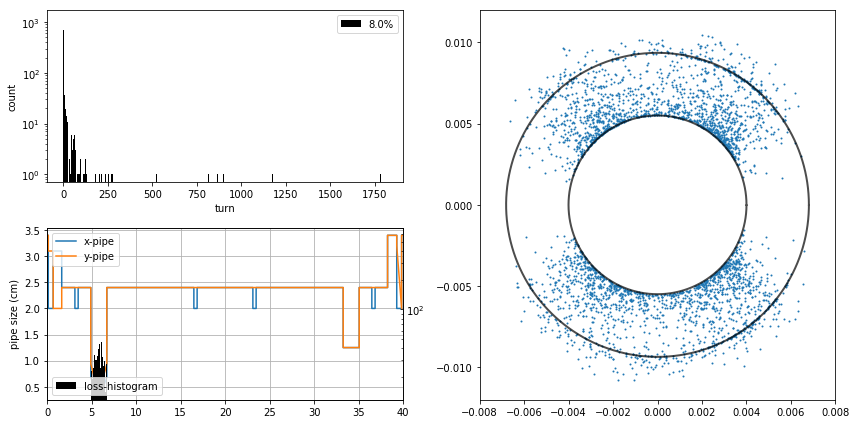

In [26]:
key='Thermal.tau=0.3.CL=6.0'
data = lostp_data[key]
lost_ratio = np.round(len(data['pLost'])/npt*100)

plt.figure(figsize=(12,6))

plt.subplot(221)
plt.hist(data['pLost'][:,0]/L,bins=2000,color='k');
plt.yscale('log')
plt.legend([str(lost_ratio)+'%'])
plt.xlabel('turn')
plt.ylabel('count')


plt.subplot(223)
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.legend(['x-pipe','y-pipe'],loc=2)
plt.xlim(0,L)
plt.ylabel('pipe size (cm)')
plt.grid()
plt.twinx()
plt.hist(np.mod(data['pLost'][:,0],L),bins=90,color='k');
plt.yscale('log')
plt.legend(['loss-histogram'],loc=3)
plt.tick_params(which='both',direction='in')


plt.subplot(122)
nlost = len(data['pLost'])
print(nlost)
alpha = np.min([1,10000/nlost])
plt.plot(ap0_x*c,ap0_y*s,alpha=0.7,c='k',lw=2)
plt.plot(ap1_x*c,ap1_y*s,alpha=0.7,c='k',lw=2)
plt.scatter(data['pLost'][:,1],data['pLost'][:,2],s=1.0,alpha=alpha)
plt.xlim(-0.008,0.008)
plt.ylim(-0.012,0.012)

plt.tight_layout()

In [ ]:
for key,dic in lostp_data.items():
    if 'Twiss0' in dic:
        dic['Twiss0'] = np.array(dic['Twiss0'])
    dic['Twiss1'] = np.array(dic['Twiss1'])

In [ ]:
for key,dic in lostp_data.items():
    print(key)
#     print('  ',dic['Twiss0'][2],dic['Twiss0'][5])
    print('  ',dic['Twiss1'][2],dic['Twiss1'][5])
    print(len(dic['pLost']))